# Contents
1. [Identify the Problem](#IP)
2. [Import the Data](#ID)
3. [Exploratory Data Analysis](#EDA)
4. [Data Cleaning](#DC)
     1. [Outlier Detection](#OD)
     2. [Missing Value Imputation](#MVI)
5. [Feature Transformation](#FT)
     1. [Convert Categorical to Numerical Data](#C2N)
     2. [Reduce Skewness](#RS)
     3. [Normalise Data Columns](#NDC)
6. [Modelling](#Mod)
     1. [Model Learning](#ML)
     2. [Model Validation](#MV)


# 1. Identify the Problem <a id='IP'></a>

Since, the problem statement says to predict the House Prices of given multiple variables.
So. it is a Multivariable Regression Problem.

# 2. Import the Data <a id='ID'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy import stats
from scipy.stats import norm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# Print some useful info for the train set
print(f'Train size is: {train.shape}')
print(f'Test size is: {test.shape}')

Train size is: (1460, 81)
Test size is: (1459, 80)


# 3. Exploratory Data Analysis <a id='EDA'></a>

First, let's Analyze the dependent Variable

In [4]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

*Skewness*

mu = 180921.20 and sigma = 79415.29


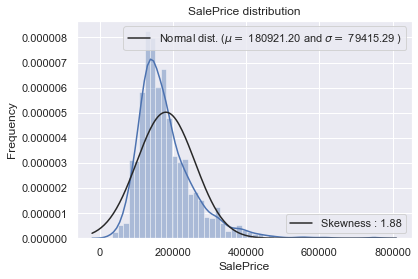

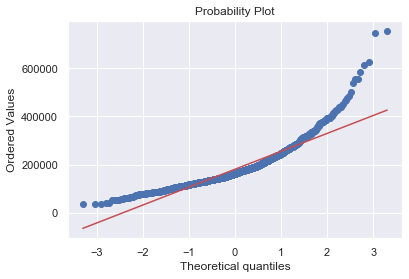

In [5]:
def distribution_plot_and_qqplot(data):
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)
    print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

    # Plot the distribution
    g = sns.distplot(data, fit=norm)
    legend1 = plt.legend(['Skewness : {:.2f}'.format(data.skew())], loc=4)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.gca().add_artist(legend1)
    plt.ylabel('Frequency')
    plt.title(f'{data.name} distribution')

    # Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(data, plot=plt)
    plt.show()
    
distribution_plot_and_qqplot(train['SalePrice'])

We can observe that the target variable:
* deviate from the normal distribution
* have appreciable positive skewness
* show peakedness
   
   
As, the data in linear models should be normally distributed, later we will transform this variable and make it more normally distributed.

*Correlation*

To explore the data, we will start with 
* Correlation matrix ie plotting heatmap.
* Scatter plots between the most correlated variables.

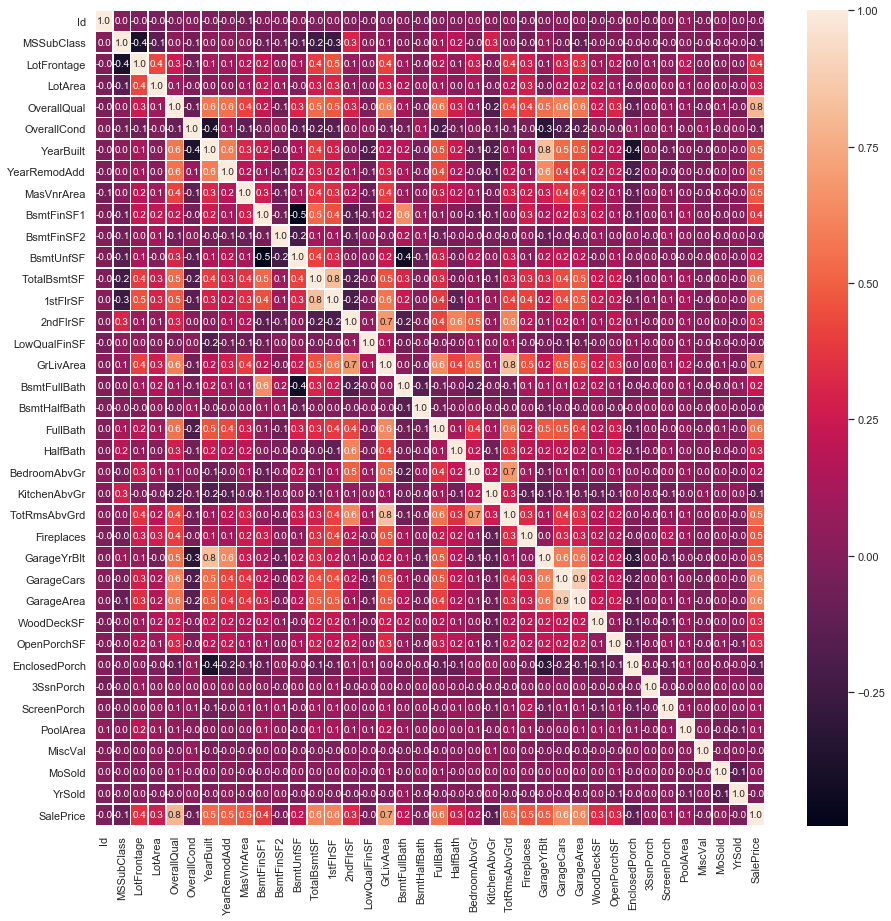

In [6]:
f,ax = plt.subplots(figsize = (15,15))
sns.heatmap(train.corr(), annot = True, linewidths=.5, fmt='.1f', ax=ax)
plt.show()

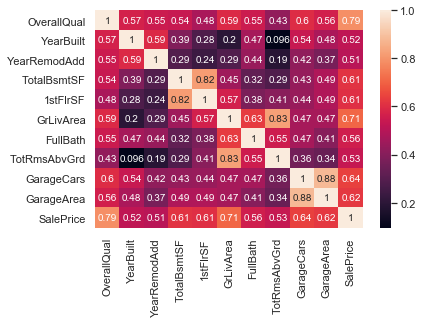

In [7]:
corre = train.corr()
top_corr_features = corre.index[abs(corre['SalePrice'])>0.5]
g = sns.heatmap(train[top_corr_features].corr(),annot=True)

These are the variables most correlated with 'SalePrice'. We can say:
* 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.
* 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, we can say, the number of       cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers.       You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep          'GarageCars' since its correlation with 'SalePrice' is higher).
* 'TotalBsmtSF' and '1stFlrSF' also seem to be twin brothers. We can keep 'TotalBsmtSF' just to say that our first guess was       right.
* 'TotRmsAbvGrd' and 'GrLivArea', twin brothers again.
* 'YearBuilt'... It seems that 'YearBuilt' is slightly correlated with 'SalePrice'.

Scatter plots between 'SalePrice' and highly correlated variables

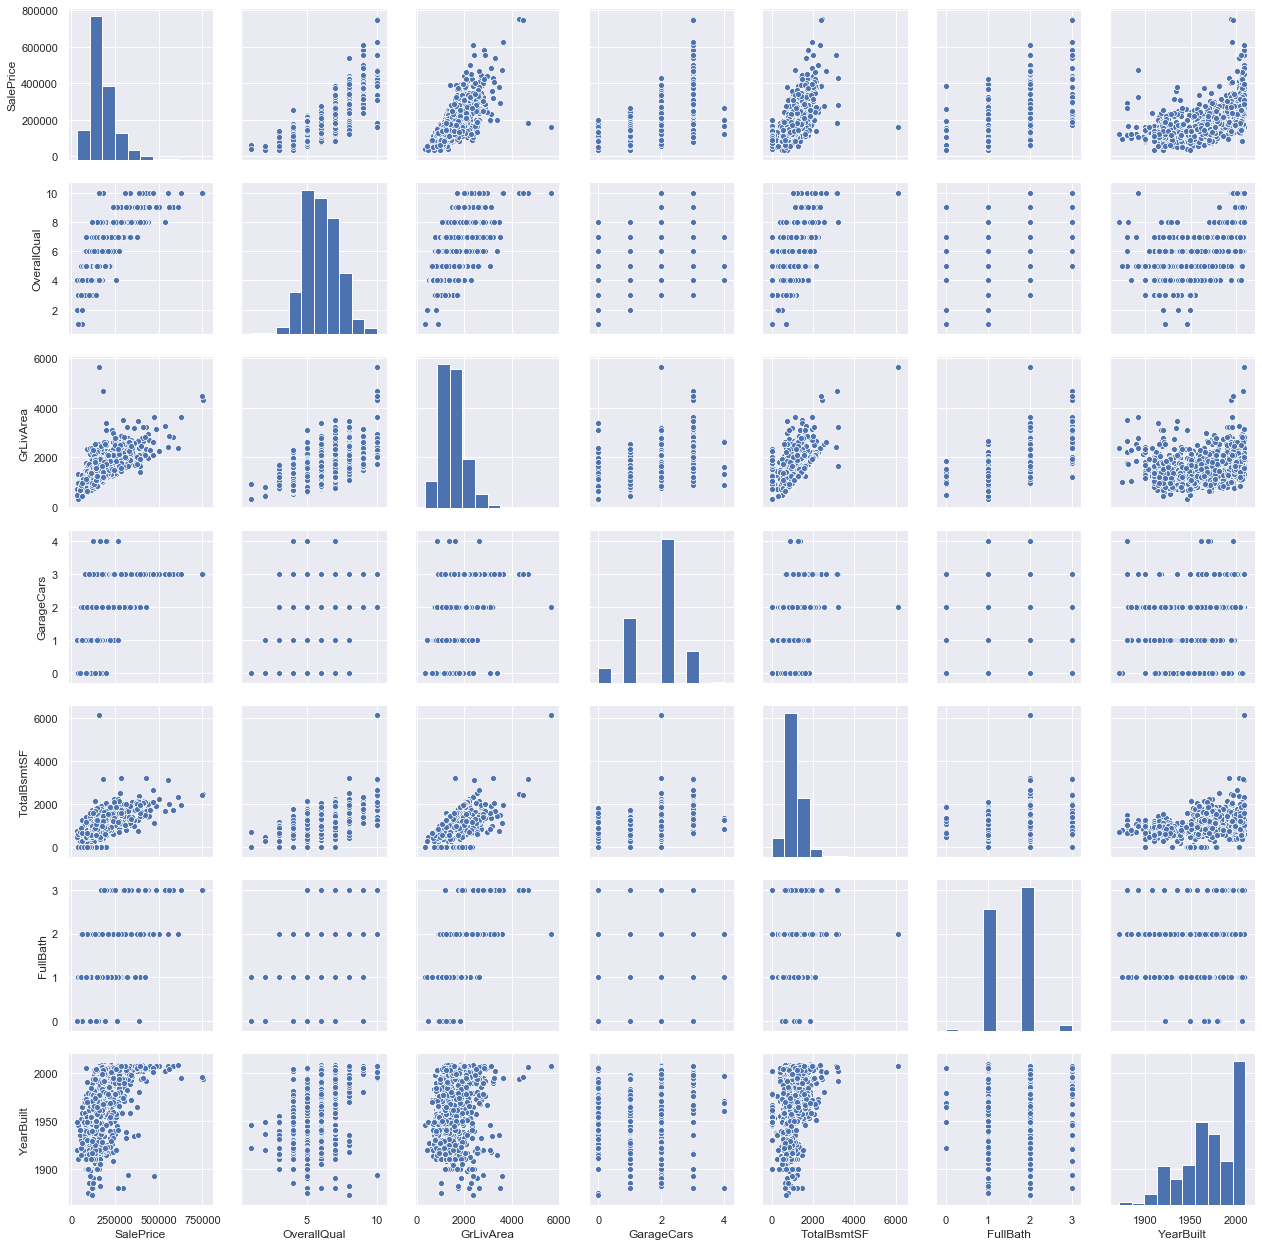

In [8]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show()

Although we already know some of the main figures, this mega scatter plot gives us a reasonable idea about variables relationships.

One of the figures we may find interesting is the one between 'TotalBsmtSF' and 'GrLiveArea'. In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area.

The plot concerning 'SalePrice' and 'YearBuilt' can also make us think. In the bottom of the 'dots cloud', we see what almost appears to be an exponential function. We can also see this same tendency in the upper limit of the 'dots cloud'. Also, notice how the set of dots regarding the last years tend to stay above this limit (I just wanted to say that prices are increasing faster now).

# 4. Data Cleaning <a id='DC'></a>

*Outlier Detection*<a id='OD'></a>

In [9]:
# Before plotting let's create a useful function to use it again later
def plot_scatter(x, y):
    fig, ax = plt.subplots()
    ax.scatter(x=x, y=y)
    plt.xlabel(x.name, fontsize=12)
    plt.ylabel(y.name, fontsize=12)
    plt.show()
    

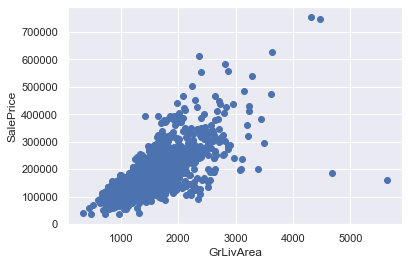

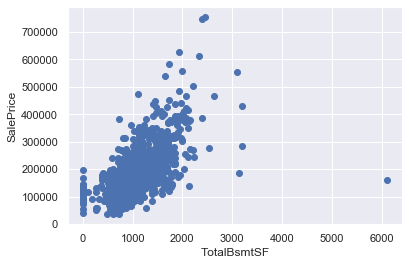

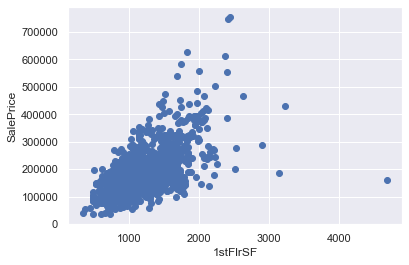

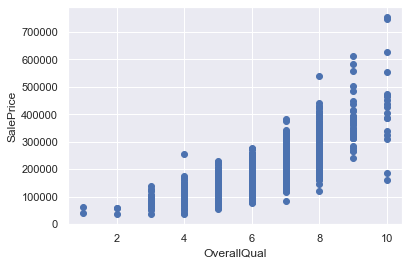

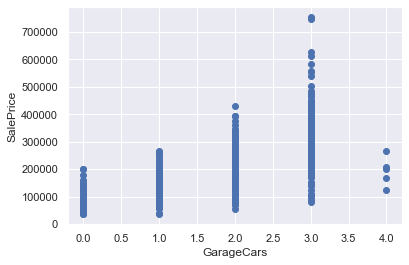

In [10]:
plot_scatter(train['GrLivArea'], train['SalePrice'])
plot_scatter(train['TotalBsmtSF'], train['SalePrice'])
plot_scatter(train['1stFlrSF'], train['SalePrice'])
plot_scatter(train['OverallQual'], train['SalePrice'])
plot_scatter(train['GarageCars'], train['SalePrice'])


We can see that there are two point with (very) large value of GrLivArea and with (very) low price. Similarily, one point each  with (very) large value of TotalBsmtSF & 1stFlrSF and with (very) low price.
These are outliers and we can safely remove them.

In [11]:
train[train.GrLivArea>4500]
train[train.TotalBsmtSF>4000]
train[train['1stFlrSF']>4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


Deleting Outliers

In [12]:
train = train.drop(train[train['Id']==524].index)
train = train.drop(train[train['Id']==1299].index)
train.shape

(1458, 81)

*Missing Value Imputation*<a id='MVI'></a>

Let's combine both train and test data to save our time and energy. :)

In [13]:
df = pd.concat([train,test])

pd.set_option('display.max_rows',5000)
pd.set_option('display.max_columns',500)


Removing the highly correlated variables

In [14]:
df = df.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd'], axis =1)


In [15]:
#checkig the columns for categorical and numerical values
print(df.select_dtypes(include = ['int64','float64']).columns)
print(df.select_dtypes(include = ['object']).columns)


Index(['2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch',
       'Fireplaces', 'FullBath', 'GarageCars', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Id', 'KitchenAbvGr', 'LotArea', 'LotFrontage',
       'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'SalePrice',
       'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd',
       'YrSold'],
      dtype='object')
Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotCo

In [16]:
df = df.set_index('Id')

In [17]:
#missing data
total_miss = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
missing_data = pd.concat([total_miss,percent], axis=1, keys=['Total','Percent'])

missing_data.head(35)

,Total,Percent
PoolQC,2908,99.691464
MiscFeature,2812,96.400411
Alley,2719,93.212204
Fence,2346,80.425094
SalePrice,1459,50.017141
FireplaceQu,1420,48.680151
LotFrontage,486,16.660953
GarageYrBlt,159,5.450806
GarageQual,159,5.450806
GarageFinish,159,5.450806


In [18]:
columns_drop =percent[percent > 20].keys()

columns_drop

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'SalePrice', 'FireplaceQu'], dtype='object')

In [19]:
df = df.drop(columns_drop, axis = 1)

print(df.shape)
df.describe(include = 'all')

(2917, 71)


,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fireplaces,Foundation,FullBath,Functional,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2917.000000,2917.000000,2917.000000,2917,2835,2835,2916.000000,2916.000000,2838,2837,2915.000000,2915.000000,2836,2916.000000,2917,2917,2917,2916,2917.000000,2917,2917,2916,2916,2917.000000,2917,2917.000000,2915,2916.000000,2758,2758,2758,2760,2758.000000,2917.000000,2917.000000,2917,2917,2917,2917.000000,2916,2917,2917,2917.000000,2917,2431.000000,2917,2917.000000,2917.000000,2913,2894.000000,2893,2917.000000,2917.000000,2917,2917.000000,2917.000000,2917.000000,2917,2917.000000,2917,2917,2917,2916,2917.000000,2917,2916.000000,2915,2917.000000,2917.000000,2917.000000,2917.000000
unique,NaN,NaN,NaN,5,4,4,NaN,NaN,6,6,NaN,NaN,4,NaN,2,9,8,5,NaN,5,4,15,16,NaN,6,NaN,7,NaN,5,3,5,6,NaN,NaN,NaN,6,5,8,NaN,4,4,3,NaN,5,NaN,4,NaN,NaN,5,NaN,4,NaN,NaN,25,NaN,NaN,NaN,3,NaN,7,6,6,9,NaN,2,NaN,2,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,1Fam,TA,No,NaN,NaN,Unf,Unf,NaN,NaN,TA,NaN,Y,Norm,Norm,SBrkr,NaN,TA,TA,VinylSd,VinylSd,NaN,PConc,NaN,Typ,NaN,TA,Unf,TA,Attchd,NaN,NaN,NaN,GasA,Ex,1Story,NaN,TA,Lvl,Gtl,NaN,Inside,NaN,Reg,NaN,NaN,RL,NaN,None,NaN,NaN,NAmes,NaN,NaN,NaN,Y,NaN,CompShg,Gable,Normal,WD,NaN,Pave,NaN,AllPub,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2423,2604,1904,NaN,NaN,851,2491,NaN,NaN,1283,NaN,2721,2511,2888,2669,NaN,2536,1798,1025,1014,NaN,1306,NaN,2715,NaN,2652,1230,2602,1722,NaN,NaN,NaN,2872,1491,1471,NaN,1492,2622,2776,NaN,2132,NaN,1859,NaN,NaN,2263,NaN,1742,NaN,NaN,443,NaN,NaN,NaN,2639,NaN,2875,2310,2402,2525,NaN,2905,NaN,2914,NaN,NaN,NaN,NaN
mean,335.861502,2.604045,2.860130,NaN,NaN,NaN,439.015432,49.616255,NaN,NaN,0.429160,0.061407,NaN,560.695816,NaN,NaN,NaN,NaN,23.114158,NaN,NaN,NaN,NaN,0.596160,NaN,1.567364,NaN,1.766118,NaN,NaN,NaN,NaN,1978.092096,1498.251628,0.379842,NaN,NaN,NaN,1.044566,NaN,NaN,NaN,10139.439150,NaN,69.180584,NaN,4.697635,57.135756,NaN,101.733587,NaN,50.860816,6.213576,NaN,47.280082,5.564964,6.086390,NaN,2.088790,NaN,NaN,NaN,NaN,16.073363,NaN,1049.327503,NaN,93.629414,1971.287967,1984.248200,2007.792938
std,428.119663,25.196714,0.822967,NaN,NaN,NaN,444.182329,169.258662,NaN,NaN,0.524002,0.245766,NaN,439.651650,NaN,NaN,NaN,NaN,64.263424,NaN,NaN,NaN,NaN,0.644773,NaN,0.552465,NaN,0.761531,NaN,NaN,NaN,NaN,25.571300,496.908626,0.502782,NaN,NaN,NaN,0.214532,NaN,NaN,NaN,7807.036512,NaN,22.791719,NaN,46.412570,42.532140,NaN,178.510291,NaN,567.595198,2.713070,NaN,67.118965,1.113414,1.406704,NaN,34.561371,NaN,NaN,NaN,NaN,56.202054,NaN,429.105905,NaN,126.532643,30.286991,20.892257,1.315328
min,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,1895.000000,334.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1300.000000,NaN,21.000000,NaN,0.000000,20.000000,NaN,0.000000,NaN,0.000000,1.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,1872.000000,1950.000000,2006.000000
25%,0.000000,0.000000,2.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,220.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,1960.000000,1126.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,7476.000000,NaN,59.000000,NaN,0.000000,20.000000,NaN,0.000000,NaN,0.000000,

Now, lets impute the missing value.

In [20]:
missing_cols = df.columns[df.isnull().any()]

missing_cols

Index(['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'SaleType', 'TotalBsmtSF', 'Utilities'],
      dtype='object')

First impute the missing values in Bsmt Features.

In [21]:
bsmt_cols = ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF','TotalBsmtSF']

bsmt_feat = df[bsmt_cols]
bsmt_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 11 columns):
BsmtCond        2835 non-null object
BsmtExposure    2835 non-null object
BsmtFinSF1      2916 non-null float64
BsmtFinSF2      2916 non-null float64
BsmtFinType1    2838 non-null object
BsmtFinType2    2837 non-null object
BsmtFullBath    2915 non-null float64
BsmtHalfBath    2915 non-null float64
BsmtQual        2836 non-null object
BsmtUnfSF       2916 non-null float64
TotalBsmtSF     2916 non-null float64
dtypes: float64(6), object(5)
memory usage: 273.5+ KB


Lets first impute the missing values in rows.

In [22]:
bsmt_feat = bsmt_feat[bsmt_feat.isnull().any(axis=1)]

#print(bsmt_feat)
print(bsmt_feat.shape)

(88, 11)


replace the NaN in categorical with NA(ie No Basement) and with 0 in Numerical data.

In [23]:
bsmt_feat_all_nan = bsmt_feat[(bsmt_feat.isnull() | bsmt_feat.isin([0])).all(1)]

#print(bsmt_feat_all_nan)
print(bsmt_feat_all_nan.shape)

(79, 11)


In [24]:
qual = list(df.loc[:,df.dtypes=='object'].columns.values)

for i in bsmt_cols:
    if i in qual:
        bsmt_feat_all_nan[i] = bsmt_feat_all_nan[i].replace(np.nan,'NA')
    else:
        bsmt_feat_all_nan[i] = bsmt_feat_all_nan[i].replace(np.nan,0)

bsmt_feat.update(bsmt_feat_all_nan)
df.update(bsmt_feat_all_nan)

In [25]:
#Finding remaining rows which have null columns

bsmt_feat = bsmt_feat[bsmt_feat.isin([np.nan]).any(axis=1)]

#print(bsmt_feat)
print(bsmt_feat.shape)

(9, 11)


Replace the BsmtFinType2 based on BsmtFinSF2 by bucketing the BsmtFinSF2.


In [26]:
#Bucket the continuous columns
print(df['BsmtFinSF2'].max())
print(df['BsmtFinSF2'].min())

#Bucket this  range in 5 buckets.
#pd.cut(range(0,1526),5)

1526.0
0.0


In [27]:
df_slice = df[(df['BsmtFinSF2'] >= 305) & (df['BsmtFinSF2'] <= 610)]

#Impute this particular row
bsmt_feat.at[333,'BsmtFinType2'] = df_slice['BsmtFinType2'].mode()[0]

In [28]:
#Impute the missing BsmtExposure value with the slice of BsmtExposure when BsmtQual is Gd.
bsmt_feat['BsmtExposure'] = bsmt_feat['BsmtExposure'].replace(np.nan, df[df['BsmtQual'] == 'Gd']['BsmtExposure'].mode()[0])

#Similarily
bsmt_feat['BsmtCond'] = bsmt_feat['BsmtCond'].replace(np.nan, df['BsmtCond'].mode()[0])
bsmt_feat['BsmtQual'] = bsmt_feat['BsmtQual'].replace(np.nan, df['BsmtQual'].mode()[0])


In [29]:
df.update(bsmt_feat)

df.columns[df.isnull().any()]

Index(['Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'SaleType', 'Utilities'],
      dtype='object')

In [30]:
#Now impute the missing values in Garage Features.

garage_cols = ['GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
       'GarageYrBlt']

gar_feat = df[garage_cols]
gar_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 6 columns):
GarageCars      2916 non-null float64
GarageCond      2758 non-null object
GarageFinish    2758 non-null object
GarageQual      2758 non-null object
GarageType      2760 non-null object
GarageYrBlt     2758 non-null float64
dtypes: float64(2), object(4)
memory usage: 159.5+ KB


In [31]:
gar_feat = gar_feat[gar_feat.isnull().any(axis=1)]

#print(gar_feat)
print(gar_feat.shape)

(159, 6)


In [32]:
gar_feat_all_nan = gar_feat[(gar_feat.isnull() | gar_feat.isin([0])).all(1)]

#print(gar_feat_all_nan)
print(gar_feat_all_nan.shape)

(157, 6)


In [33]:
for i in garage_cols:
    if i in qual:
        gar_feat_all_nan[i] = gar_feat_all_nan[i].replace(np.nan,'NA')
    else:
        gar_feat_all_nan[i] = gar_feat_all_nan[i].replace(np.nan,0)
gar_feat.update(gar_feat_all_nan)
df.update(gar_feat_all_nan)

In [34]:
gar_feat = gar_feat[gar_feat.isnull().any(axis=1)]

#gar_feat

In [35]:
for i in garage_cols:
    gar_feat[i] = gar_feat[i].replace(np.nan, df[df['GarageType'] == 'Detchd'][i].mode()[0])

#gar_feat

In [36]:
df.update(gar_feat)

df.columns[df.isnull().any()]

Index(['Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
       'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'SaleType',
       'Utilities'],
      dtype='object')

In [37]:
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])

df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])

df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])

df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])

df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])

In [38]:
df[df['MasVnrArea'].isnull() == True]['MasVnrType'].unique()

array(['None'], dtype=object)

In [39]:
df.loc[(df['MasVnrType'] == 'None') & (df['MasVnrArea'].isnull() == True), 'MasVnrArea'] = 0

In [40]:
#print(df['MasVnrArea'].isnull().sum())
#print(df['MasVnrType'].isnull().sum())
#print(df.columns[df.isnull().any()])

In [41]:
lotconfig = ['Corner','Inside','CulDSac','FR2','FR3']

for i in lotconfig:
    df['LotFrontage'] = pd.np.where((df['LotFrontage'].isnull() == True) & (df['LotConfig'] == i), df[df['LotConfig'] == i]['LotFrontage'].mean(),df['LotFrontage'])

df.isnull().sum().max()

0

# 5. Feature Transformation <a id='FT'></a>

*Dealing with the Categorical Data*<a id='C2N'></a>

In [42]:
#Few Features are in numerical in nature but actually are of Categorical

cat_con_columns = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt','YrSold']
for i in cat_con_columns:
    df[i] = df[i].astype(str)

In [43]:
import calendar
df['MoSold'] = df['MoSold'].apply(lambda x : calendar.month_abbr[x])

df['MoSold'].unique()

array(['Feb', 'May', 'Sep', 'Dec', 'Oct', 'Aug', 'Nov', 'Apr', 'Jan',
       'Jul', 'Mar', 'Jun'], dtype=object)

In [44]:
quan = list(df.loc[:,df.dtypes != 'object'].columns.values)


In [45]:
# Ordered Data
from pandas.api.types import CategoricalDtype

df['BsmtCond'] = df['BsmtCond'].astype(CategoricalDtype(categories=['NA','Po','Fa','TA','Gd','Ex'], ordered = True)).cat.codes

df['BsmtExposure'] = df['BsmtExposure'].astype(CategoricalDtype(categories=['NA','No','Mn','Av','Gd'], ordered = True)).cat.codes

df['BsmtFinType1'] = df['BsmtFinType1'].astype(CategoricalDtype(categories=['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'], ordered = True)).cat.codes

df['BsmtFinType2'] = df['BsmtFinType2'].astype(CategoricalDtype(categories=['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'], ordered = True)).cat.codes

df['BsmtQual'] = df['BsmtQual'].astype(CategoricalDtype(categories=['NA','Po','Fa','TA','Gd','Ex'], ordered = True)).cat.codes

df['ExterQual'] = df['BsmtQual'].astype(CategoricalDtype(categories=['Po','Fa','TA','Gd','Ex'], ordered = True)).cat.codes

df['ExterCond'] = df['ExterCond'].astype(CategoricalDtype(categories=['Po','Fa','TA','Gd','Ex'], ordered = True)).cat.codes

df['Functional'] = df['Functional'].astype(CategoricalDtype(categories=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'], ordered = True)).cat.codes

df['GarageCond'] = df['GarageCond'].astype(CategoricalDtype(categories=['NA','Po','Fa','TA','Gd','Ex'], ordered = True)).cat.codes

df['GarageQual'] = df['GarageQual'].astype(CategoricalDtype(categories=['NA','Po','Fa','TA','Gd','Ex'], ordered = True)).cat.codes

df['GarageFinish'] = df['GarageFinish'].astype(CategoricalDtype(categories=['NA','Unf','RFn','Fin'], ordered = True)).cat.codes

df['HeatingQC'] = df['HeatingQC'].astype(CategoricalDtype(categories=['Po','Fa','TA','Gd','Ex'], ordered = True)).cat.codes

df['KitchenQual'] = df['KitchenQual'].astype(CategoricalDtype(categories=['Po','Fa','TA','Gd','Ex'], ordered = True)).cat.codes

df['PavedDrive'] = df['PavedDrive'].astype(CategoricalDtype(categories=['N','P','Y'], ordered = True)).cat.codes

df['Utilities'] = df['Utilities'].astype(CategoricalDtype(categories=['ELO','NoSeWa','NoSewr','AllPub'], ordered = True)).cat.codes


*Reducing Skewness among numerical data* <a id='RS'></a>

In [46]:
skewed_features = ['2ndFlrSF','3SsnPorch',
 'BedroomAbvGr','BsmtFinSF1','BsmtFinSF2',
 'BsmtFullBath','BsmtHalfBath','BsmtUnfSF',
 'EnclosedPorch','Fireplaces','FullBath',
 'GarageCars','GrLivArea', 'HalfBath',
 'KitchenAbvGr','LotArea','LotFrontage',
 'LowQualFinSF','MasVnrArea','MiscVal',
 'OpenPorchSF','PoolArea','ScreenPorch',
 'TotalBsmtSF','WoodDeckSF']

mu = 12.02 and sigma = 0.40


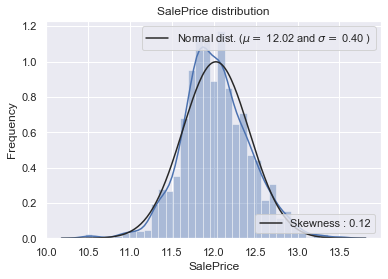

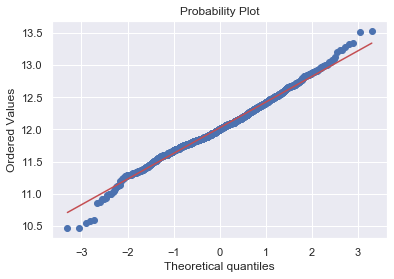

In [47]:
## Remove Skewness from the data
for i in skewed_features:
    df[i] = np.log1p(df[i])

log_SalePrice = np.log1p(train['SalePrice'])

distribution_plot_and_qqplot(log_SalePrice)

*Normalisation* <a id='NDC'></a>

In [48]:
# Create Dummies for all non ordinal categorical data
qual1 = list(df.loc[:,df.dtypes == 'object'].columns.values)
print(len(qual1))

df_with_dummies = pd.get_dummies(df, columns=qual1, drop_first=True)
df_with_dummies.shape


29


(2917, 496)

In [49]:
##Normalize

df_inputs = df_with_dummies.copy()
targets = log_SalePrice.copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_inputs)
df_inputs_scaled = scaler.transform(df_inputs)

# 6. Modelling <a id='Mod'></a>

In [50]:
#Segregate data into original train and test
train_len = len(train)
train_scaled = df_inputs_scaled[:train_len]
test_scaled = df_inputs_scaled[train_len:]

print(train_scaled.shape)

print(test_scaled.shape)


(1458, 496)
(1459, 496)


In [51]:
# Train Test Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_scaled, targets, test_size=0.2, random_state=365)


Model Learning <a id='ML'></a>

In [52]:
import xgboost
regressor = xgboost.XGBRegressor(learning_rate = 0.06, max_depth= 3, n_estimators = 350, random_state= 0)
regressor.fit(x_train,y_train)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
y_hat = regressor.predict(x_train)

plt.scatter(y_train, y_hat, alpha = 0.2)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

In [ ]:
regressor.score(x_train,y_train)

In [ ]:
##Testing
y_hat_test = regressor.predict(x_test)


plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.show()

In [ ]:
y_predict = regressor.predict(test_scaled)
y_predict = np.expm1(y_predict)

Model Validation <a id='MV'></a>

In [ ]:
## k-Fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regressor, X = x_train, y = y_train, cv = 10)


In [ ]:
print(accuracies.mean())
print(accuracies.std())